<a href="https://colab.research.google.com/github/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/Revision/pseudoBulkStarvation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Mon May 10 17:37:05 UTC 2021


### **Download Data**

In [1]:
import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

In [2]:
#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
download_file('10.22002/D1.1797','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1797.gz'

In [3]:
#CellRanger Starvation h5ad data
download_file('10.22002/D1.1798','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1798.gz'

In [4]:
#Saved DeSeq2 Results for Fed/Starved (Differentially expressed under starvation --> perturbed genes)
download_file('10.22002/D1.1810','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1810.gz'

In [5]:
#Kallisto bus clustered starvation data, h5ad
download_file('10.22002/D1.1796','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1796.gz'

In [6]:
#Human ortholog annotations
download_file('10.22002/D1.1819','.gz')

#Panther annotations
download_file('10.22002/D1.1820','.gz')

#GO Terms
download_file('10.22002/D1.1822','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1822.gz'

In [7]:
!gunzip *.gz

In [8]:
#Install packages
!pip install --quiet anndata
!pip install --quiet scanpy==1.6.0

!pip3 install --quiet rpy2

     |████████████████████████████████| 133kB 16.2MB/s 
     |████████████████████████████████| 7.7MB 9.1MB/s 
     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 1.2MB 49.6MB/s 


### **Import Packages**

In [9]:
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.preprocessing import scale

import random

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")
%load_ext rpy2.ipython

In [ ]:
# See version of all installed packages, last done 11/27/2020
# !pip list -v > pkg_vers_20201127.txt

In [10]:
#Read in annotations
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('D1.1819'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]


panther_df = pd.read_csv('D1.1820',
            sep="\t",header=None) #skiprows=[0,1,2,3]



goTerm_df = pd.read_csv('D1.1822',
            sep=" ",header=None) #skiprows=[0,1,2,3]

In [74]:
scDE = pd.read_csv('D1.1810')
scDE.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Genes,Cluster,Condition,padj,padjClus,log2FC,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms,geneClus
0,0,0,1,XLOC_028699,0,Starved,5.554489e-16,1.832981e-14,-1.284301,NaN,NaN,NaN,NaN,NaN,4
1,1,1,2,XLOC_010635,0,Starved,2.528288e-14,8.343350e-13,-1.492625,SRSF1,serine/arginine-rich splicing factor 1 isofor...,['PTHR24012:SF650'],['SERINE/ARGININE-RICH SPLICING FACTOR 1'],[nan],4
2,2,2,3,XLOC_011294,0,Starved,8.348790e-14,2.755101e-12,-1.441413,NaN,NaN,NaN,NaN,[nan],0
3,3,3,4,XLOC_034889,0,Starved,1.786565e-13,5.895663e-12,-1.448216,NaN,NaN,['PTHR13680:SF29'],['CDGSH IRON-SULFUR DOMAIN-CONTAINING PROTEIN ...,[nan],1
4,4,4,5,XLOC_030861,0,Starved,8.598653e-12,2.837556e-10,-1.570453,SRSF1,serine/arginine-rich splicing factor 1 isofor...,['PTHR24012:SF650'],['SERINE/ARGININE-RICH SPLICING FACTOR 1'],[nan],4


### **Run DeSeq2 Analysis for Starvation Pseudo-Bulk Data**

In [12]:
#Remove clusters with < 10 cells per condition

#Read in previously saved data
bus_fs_clus = anndata.read("D1.1796")
print(bus_fs_clus )

bus_fs_raw = anndata.read("D1.1797")

bus_fs_raw = bus_fs_raw[bus_fs_clus.obs_names,]
bus_fs_raw.obs['orgID'] = bus_fs_clus.obs['orgID']
bus_fs_raw.obs['fed'] = bus_fs_clus.obs['fed']
bus_fs_raw.obs['cellRanger_louvain'] = bus_fs_clus.obs['cellRanger_louvain']


sc.pp.filter_cells(bus_fs_raw, min_counts=1)
sc.pp.filter_genes(bus_fs_raw, min_counts=1)
bus_fs_raw

#clusSize

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


AnnData object with n_obs × n_vars = 13673 × 28514
    obs: 'batch', 'orgID', 'fed', 'cellRanger_louvain', 'n_counts'
    var: 'n_counts'

In [ ]:
#Instantiate dataframe with gene names
def makeDF_forR(sub_raw):
  counts = np.zeros((10,len(sub_raw.var_names)))
  orgs = [int(i) for i in np.unique(sub_raw.obs['orgID'])]
  mat = scipy.sparse.csr_matrix.toarray(sub_raw.X)
  for i in np.unique(orgs):
    sub_mat = mat[sub_raw.obs['orgID'] == str(i),:]

    counts[i-1,:] = sub_mat.sum(axis=0)

  fullDF = pd.DataFrame(counts.T, index = sub_raw.var_names.tolist(), columns= np.unique(orgs))
  conds = ['True']*5 + ['False']*5

  reps = [1,2,3,4,5] + [1,2,3,4,5]

  sampleDF = pd.DataFrame({'org_ID': fullDF.columns}) \
          .assign(condition = conds) \
          .assign(replicate = reps)
  sampleDF.index = sampleDF.org_ID

  fullDF.to_csv('fullDF.csv')
  sampleDF.to_csv('sampleDF.csv')
  
  sampleDF.head()

In [ ]:
makeDF_forR(bus_fs_raw)

In [ ]:
%%R 
fullDF <- read.csv(file = 'fullDF.csv')
sampleDF <- read.csv(file = 'sampleDF.csv')
head(sampleDF)

  org_ID org_ID.1 condition replicate
1      1        1      True         1
2      2        2      True         2
3      3        3      True         3
4      4        4      True         4
5      5        5      True         5
6      6        6     False         1


In [ ]:
%%R
head(fullDF)

                               X    X1    X2    X3    X4    X5    X6    X7
1 TRINITY_DN16756_c0_g1_i8.mrna1     1     2     0     1     3     1     3
2                    XLOC_000078 26625 25512 32083 25328 40905 23154 32959
3                    XLOC_000001     8     6     4     9    15     7     8
4                    XLOC_000002     5     7     9     4     6     5     5
5                    XLOC_000098    70    74    83    63    94    51    71
6                    XLOC_000084    32    30    21    22    52    22    34
     X8    X9   X10
1     1     2     2
2 28419 31003 25444
3     8     5     4
4     6    11     5
5    64   119    65
6    33    33    30


In [ ]:
%%R
rownames(sampleDF) <- sampleDF$org_ID 

rownames(fullDF) <- fullDF$X
#colnames(fullDF) <- gsub("\\.", "-", colnames(fullDF))
fullDF <- subset(fullDF, select = -c(X) )
head(fullDF)

sampleDF <- subset(sampleDF, select = -c(org_ID.1) )
# head(sampleDF)
sampleDF$condition <- factor(sampleDF$condition, labels = c("starved", "fed"))
head(sampleDF)

  org_ID condition replicate
1      1       fed         1
2      2       fed         2
3      3       fed         3
4      4       fed         4
5      5       fed         5
6      6   starved         1


In [ ]:
%%R
head(fullDF)

                                  X1    X2    X3    X4    X5    X6    X7    X8
TRINITY_DN16756_c0_g1_i8.mrna1     1     2     0     1     3     1     3     1
XLOC_000078                    26625 25512 32083 25328 40905 23154 32959 28419
XLOC_000001                        8     6     4     9    15     7     8     8
XLOC_000002                        5     7     9     4     6     5     5     6
XLOC_000098                       70    74    83    63    94    51    71    64
XLOC_000084                       32    30    21    22    52    22    34    33
                                  X9   X10
TRINITY_DN16756_c0_g1_i8.mrna1     2     2
XLOC_000078                    31003 25444
XLOC_000001                        5     4
XLOC_000002                       11     5
XLOC_000098                      119    65
XLOC_000084                       33    30


In [ ]:
%%R
#Set up R environment
install.packages("BiocManager")
BiocManager::install(version = "3.10")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.14.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 48395 bytes (47 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[


Error: Bioconductor version '3.10' requires R version '3.6'; use
  `BiocManager::install(version = '3.12')` with R version 4.0; see
  https://bioconductor.org/install


In [ ]:
!sudo apt-get update
!sudo apt-get install libxml2-dev
!sudo apt-get install r-cran-xml
!sudo apt-get install libcurl4-openssl-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [55.5 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nvi

In [ ]:
%%R 
#install.packages("DESeq2",repos = "http://cran.us.r-project.org")
BiocManager::install("DESeq2")

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


R[write to console]: Bioconductor version 3.12 (BiocManager 1.30.14), R 4.0.5 (2021-03-31)

R[write to console]: Installing package(s) 'BiocVersion', 'DESeq2'

R[write to console]: also installing the dependencies ‘bit’, ‘bitops’, ‘formatR’, ‘bit64’, ‘plogr’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘matrixStats’, ‘lambda.r’, ‘futile.options’, ‘RSQLite’, ‘xtable’, ‘GenomeInfoDb’, ‘XVector’, ‘MatrixGenerics’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘AnnotationDbi’, ‘annotate’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘genefilter’, ‘locfit’, ‘geneplotter’, ‘RcppArmadillo’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/bit_4.0.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  leng

Update all/some/none? [a/s/n]: a


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/devtools_2.4.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 370717 bytes (362 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to consol

In [ ]:
#Make output directory
!mkdir kallistoDEAnalysis_BulkStarv

In [ ]:
%%R 
#Run DeSeq2 for each of the cell types (between control and starved cells)
#install.packages("DESeq2",repos = "http://cran.us.r-project.org")
library("DESeq2")


Genes <- c()
Condition <- c() 
padj <- c()
log2FC <- c()

sampleDF$replicate <- factor(sampleDF$replicate)


dds <- DESeqDataSetFromMatrix(countData = fullDF, colData = sampleDF, design= ~replicate + condition)

#Set control condition
dds$condition <- relevel(dds$condition, ref = 'fed')
dds <- DESeq(dds)#parallel = TRUE, test="LRT", sfType="poscounts", useT=TRUE, betaPrior = FALSE, reduced=~replicate

#Starv v Fed results
res <- results(dds,alpha=0.05,name="condition_starved_vs_fed")
resLFC <- res 
print(res)

resLFC <- na.omit(resLFC)
resOrdered <- resLFC[resLFC$padj < .05,]
#Keep log2 fold changes < -1 or > 1
resOrdered <- resOrdered[abs(resOrdered$log2FoldChange) > 1,] 
outcomes <- resOrdered[order(resOrdered$padj),]

Genes <- c(Genes,row.names(outcomes))
Condition <- c(Condition,rep('Starved',length(row.names(outcomes)))) 
padj <- c(padj,outcomes$padj)
log2FC <- c(log2FC,outcomes$log2FoldChange)
         
    


deGenesDF <- data.frame(matrix(ncol = 4, nrow = length(Genes)))
names(deGenesDF) <- c("Genes", "Condition","padj","log2FC")

deGenesDF$Genes <- Genes
deGenesDF$Condition <- Condition
deGenesDF$padj <- padj
deGenesDF$log2FC <- log2FC

write.csv(deGenesDF,'./kallistoDEAnalysis_BulkStarv/deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample.csv')

head(deGenesDF)

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



log2 fold change (MLE): condition starved vs fed 
Wald test p-value: condition starved vs fed 
DataFrame with 28514 rows and 6 columns
                                  baseMean log2FoldChange     lfcSE      stat
                                 <numeric>      <numeric> <numeric> <numeric>
TRINITY_DN16756_c0_g1_i8.mrna1     1.55500      0.7675817  1.179581  0.650724
XLOC_000078                    28439.29277      0.1460144  0.181790  0.803202
XLOC_000001                        7.19065     -0.0921588  0.607288 -0.151755
XLOC_000002                        6.10413      0.2403025  0.614529  0.391035
XLOC_000098                       72.95837      0.1279448  0.253031  0.505648
...                                    ...            ...       ...       ...
XLOC_045840                      3.1243968      0.6843294  0.827221  0.827263
TRINITY_DN34064_c0_g1_i2.mrna2   0.1258442      0.7911604  3.159477  0.250409
XLOC_045868                    228.1624335      0.1539154  0.230383  0.668085
XLOC_04

In [ ]:
deseq_df = pd.read_csv('./kallistoDEAnalysis_BulkStarv/deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample.csv')
deseq_df.head()

,Unnamed: 0,Genes,Condition,padj,log2FC
0,1,XLOC_043124,Starved,3.196685e-17,-2.741664
1,2,XLOC_002766,Starved,1.555994e-13,5.112107
2,3,XLOC_043545,Starved,2.695111e-11,-3.198908
3,4,XLOC_036532,Starved,7.111909e-10,-2.029091
4,5,XLOC_019491,Starved,5.876118e-09,-2.284475


In [ ]:
orthoGene = []
orthoDescr = []

pantherNum = []
pantherDescr = []

goTerms = []


for g in deseq_df.Genes:
        
  sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
  panth_df = panther_df[panther_df[0].isin([g])]
  go_df = goTerm_df[goTerm_df[0].isin([g])]

  if len(sub_df) > 0:
    #Save first result for gene/description
    orthoGene += [list(sub_df.Gene)[0]]
    orthoDescr += [list(sub_df.Description)[0]]
  else:
    orthoGene += ['NA']
    orthoDescr += ['NA']


  if len(panth_df) > 0:
    #Save first result for gene/description
    pantherNum += [list(panth_df[1])]
    pantherDescr += [list(panth_df[2])]
  else:
    pantherNum += ['NA']
    pantherDescr += ['NA']


  if len(go_df) > 0:
    #Save first result for gene/description
    goTerms += [list(go_df[1])]
  else:
    goTerms += ['NA']
 
deseq_df['orthoGene'] = orthoGene
deseq_df['orthoDescr'] = orthoDescr

deseq_df['pantherID'] = pantherNum
deseq_df['pantherDescr'] = pantherDescr

deseq_df['goTerms'] = goTerms
deseq_df.head()

,Unnamed: 0,Genes,Condition,padj,log2FC,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,1,XLOC_043124,Starved,3.196685e-17,-2.741664,NA,NA,[PTHR24250:SF27],[ELASTASE 2-LIKE],[nan]
1,2,XLOC_002766,Starved,1.555994e-13,5.112107,NA,NA,NA,NA,[nan]
2,3,XLOC_043545,Starved,2.695111e-11,-3.198908,NA,NA,NA,NA,[nan]
3,4,XLOC_036532,Starved,7.111909e-10,-2.029091,NA,NA,[PTHR37687],[AGAP006772-PA],[nan]
4,5,XLOC_019491,Starved,5.876118e-09,-2.284475,NA,NA,NA,NA,[nan]


In [ ]:
deseq_df.to_csv('./kallistoDEAnalysis_BulkStarv/bulk_annos_deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample.csv',index=None)


In [72]:
deseq_df = pd.read_csv('/content/bulk_annos_deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample (1).csv')

deseq_df.head()


,Unnamed: 0,Genes,Condition,padj,log2FC,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms,BulkDE
0,1,XLOC_043124,Starved,3.196685e-17,-2.741664,NaN,NaN,['PTHR24250:SF27'],['ELASTASE 2-LIKE'],[nan],Bulk Only
1,2,XLOC_002766,Starved,1.555994e-13,5.112107,NaN,NaN,NaN,NaN,[nan],Bulk Only
2,3,XLOC_043545,Starved,2.695111e-11,-3.198908,NaN,NaN,NaN,NaN,[nan],Overlap
3,4,XLOC_036532,Starved,7.111909e-10,-2.029091,NaN,NaN,['PTHR37687'],['AGAP006772-PA'],[nan],Overlap
4,5,XLOC_019491,Starved,5.876118e-09,-2.284475,NaN,NaN,NaN,NaN,[nan],Overlap


In [14]:
scDE.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Genes,Cluster,Condition,padj,padjClus,log2FC,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms,geneClus
0,0,0,1,XLOC_028699,0,Starved,5.554489e-16,1.832981e-14,-1.284301,NaN,NaN,NaN,NaN,NaN,4
1,1,1,2,XLOC_010635,0,Starved,2.528288e-14,8.343350e-13,-1.492625,SRSF1,serine/arginine-rich splicing factor 1 isofor...,['PTHR24012:SF650'],['SERINE/ARGININE-RICH SPLICING FACTOR 1'],[nan],4
2,2,2,3,XLOC_011294,0,Starved,8.348790e-14,2.755101e-12,-1.441413,NaN,NaN,NaN,NaN,[nan],0
3,3,3,4,XLOC_034889,0,Starved,1.786565e-13,5.895663e-12,-1.448216,NaN,NaN,['PTHR13680:SF29'],['CDGSH IRON-SULFUR DOMAIN-CONTAINING PROTEIN ...,[nan],1
4,4,4,5,XLOC_030861,0,Starved,8.598653e-12,2.837556e-10,-1.570453,SRSF1,serine/arginine-rich splicing factor 1 isofor...,['PTHR24012:SF650'],['SERINE/ARGININE-RICH SPLICING FACTOR 1'],[nan],4


In [15]:
len(set(deseq_df.Genes).intersection(scDE.Genes))/len(deseq_df.Genes)

0.695067264573991

In [90]:
raw = bus_fs_raw.copy()
sc.pp.normalize_per_cell(raw, counts_per_cell_after=1e4)
#sc.pp.log1p(raw)

raw


AnnData object with n_obs × n_vars = 13673 × 28514
    obs: 'batch', 'orgID', 'fed', 'cellRanger_louvain', 'n_counts'
    var: 'n_counts'

In [91]:
allBulk = list(deseq_df.Genes)
onlyBulk = [i for i in deseq_df.Genes if i not in list(scDE.Genes)]

In [132]:
singleDE = raw[:,list(scDE.Genes)].X.todense().mean(axis=0).tolist()[0]
print(len(singleDE))

allBDE = raw[:,allBulk].X.todense().mean(axis=0).tolist()[0]
print(len(allBDE ))
bOnlyDE = raw[:,onlyBulk].X.todense().mean(axis=0).tolist()[0]
print(len(bOnlyDE))

3109
223
68


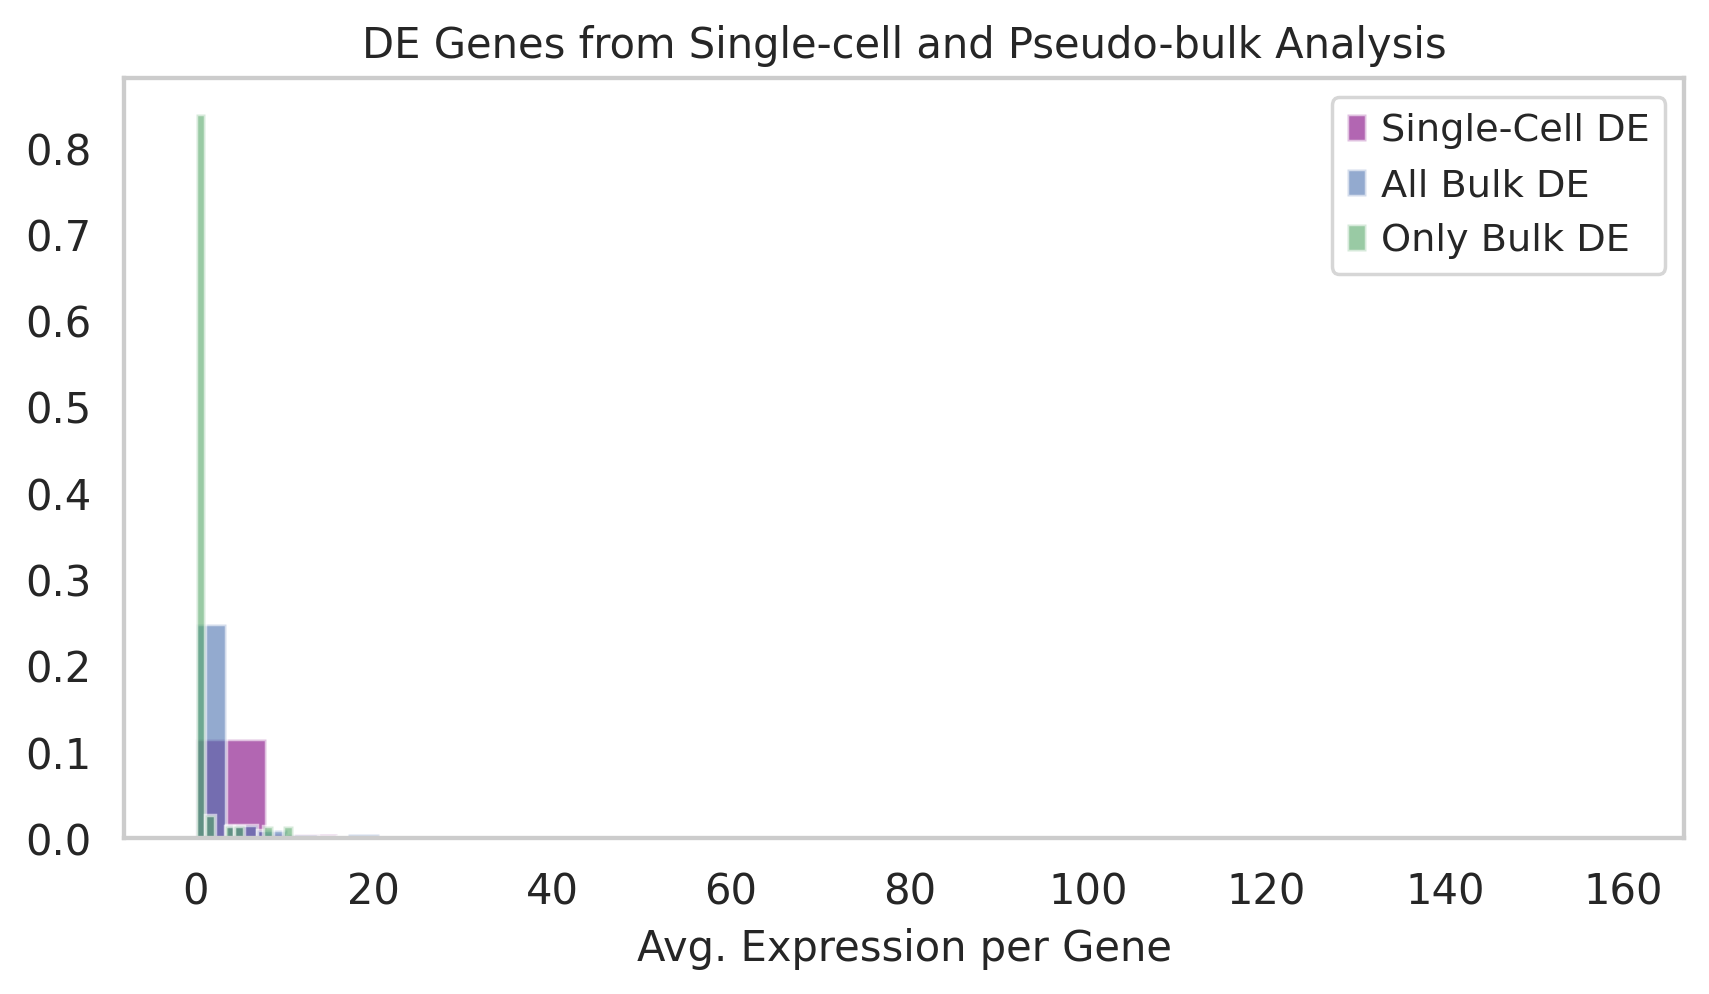

In [138]:
#Plot expression histograms for scDE genes, bulk DE genes, and bulk only DE genes
plt.figure(figsize=(8,4))
plt.hist(singleDE,bins=20,color='purple',alpha=0.6,label='Single-Cell DE',density=True)

plt.hist(allBDE,bins=15, color='b',alpha=0.6,label='All Bulk DE',density=True)

plt.hist(bOnlyDE,bins=10,color = 'g',alpha=0.6,label='Only Bulk DE',density=True)
plt.legend(loc='upper right')
plt.title('DE Genes from Single-cell and Pseudo-bulk Analysis')
plt.grid(b=None)
plt.xlabel("Avg. Expression per Gene")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
bulkDE = []
for i in deseq_df.Genes:
    if i in onlyBulk:
      bulkDE += ['Bulk Only']
    else:
      bulkDE += ['Overlap']

deseq_df['BulkDE'] = bulkDE

In [ ]:
deseq_df.to_csv('./kallistoDEAnalysis_BulkStarv/bulk_annos_deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample.csv',index=None)